In [ ]:
!pip install tensorflow numpy pandas scikit-learn matplotlib openpyxl



You should consider upgrading via the 'D:\3. apps\24. python\3. python 3.9.11\python.exe -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# Load the data
file_path = 'unique_dates.xlsx'
df_relevant_dates = pd.read_excel(file_path)
X, y = load_data(df_relevant_dates)

In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_data(df):
    """
    Load the spectral bands and FAIs for each date in the DataFrame.
    Convert FAI values to one-hot encoding for multi-class segmentation.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Unique_Dates' column.

    Returns:
        X (np.array): Input data (bands).
        y (np.array): One-hot encoded output data (FAI masks).
    """
    X = []
    y = []

    for index, row in df.iterrows():
        date_str = pd.to_datetime(row['Unique_Dates']).strftime('%Y-%m-%d')
        
        band2 = np.load(f'msi_array/msi_array_band2_{date_str}.npy')
        band3 = np.load(f'msi_array/msi_array_band3_{date_str}.npy')
        band4 = np.load(f'msi_array/msi_array_band4_{date_str}.npy')
        band8 = np.load(f'msi_array/msi_array_band8_{date_str}.npy')
        band11 = np.load(f'msi_array/msi_array_band11_{date_str}.npy')
        
        fai = np.load(f'fai_mask/fai_mask_{date_str}.npy')
        
        # Stack the bands to create the input (shape: 255, 255, 5)
        X.append(np.stack([band2, band3, band4, band8, band11], axis=-1))
        
        # Convert the FAI mask to one-hot encoding (shape: 255, 255, 3)
        fai_one_hot = to_categorical(fai, num_classes=3)
        y.append(fai_one_hot)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Load the data
# Load the data
file_path = 'unique_dates.xlsx'
df_relevant_dates = pd.read_excel(file_path)
X, y = load_data(df_relevant_dates)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
X.shape


(132, 255, 255, 5)

In [87]:
pip install tensorflow==2.11


In [88]:
import tensorflow as tf

# Check if TensorFlow can access a GPU
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")


GPU is not available.


In [81]:
y.shape

(132, 255, 255, 3)

In [53]:
y[0]

array([[[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       ...,

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]])

In [82]:
from tensorflow.keras import layers, models

def unet_model(input_shape):
    """
    Define the U-Net model for semantic segmentation (multi-class).
    
    Parameters:
        input_shape (tuple): The shape of the input image.

    Returns:
        model (tf.keras.Model): U-Net model.
    """
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.UpSampling2D((2, 2))(conv4)
    # Ensure both feature maps are the same size by padding the smaller map
    up5 = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(up5)  # Pad to match conv3
    concat5 = layers.concatenate([conv3, up5], axis=-1)

    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D((2, 2))(conv5)
    # Ensure both feature maps are the same size by padding the smaller map
    up6 = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(up6)  # Pad to match conv2
    concat6 = layers.concatenate([conv2, up6], axis=-1)

    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D((2, 2))(conv6)
    # Ensure both feature maps are the same size by padding the smaller map
    up7 = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(up7)  # Pad to match conv1
    concat7 = layers.concatenate([conv1, up7], axis=-1)

    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer with softmax activation for multi-class
    outputs = layers.Conv2D(3, (1, 1), activation='softmax')(conv7)

    model = models.Model(inputs, outputs)

    return model

# Define the model
input_shape = X_train.shape[1:]  # Shape of the input images
model = unet_model(input_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 255, 255,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 255, 255,  │      2,944 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 255, 255,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 127, 127,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 127, 127,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 63, 63,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 63, 63,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 63, 63,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 31, 31,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 31, 31,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 31, 31,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 62, 62,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 63, 63,    │          0 │ up_sampling2d[0]… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 63, 63,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 768)              │            │ zero_padding2d[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 63, 63,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 63, 63,    │    590,080 │ conv2d_8[0][0]  

 Total params: 7,784,195 (29.69 MB)

 Trainable params: 7,784,195 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=10)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 106s 9s/step - accuracy: 0.4056 - loss: 1.6809 - val_accuracy: 0.8198 - val_loss: 0.7247
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.8100 - loss: 0.6145 - val_accuracy: 0.8431 - val_loss: 0.4123
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 94s 9s/step - accuracy: 0.8391 - loss: 0.4628 - val_accuracy: 0.8828 - val_loss: 0.3477
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.8433 - loss: 0.4157 - val_accuracy: 0.8739 - val_loss: 0.3510
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 95s 9s/step - accuracy: 0.8540 - loss: 0.3878 - val_accuracy: 0.8874 - val_loss: 0.3203
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 208s 20s/step - accuracy: 0.8805 - loss: 0.3335 - val_accuracy: 0.8957 - val_loss: 0.3110
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 225s 20s/step - accuracy: 0.8977 - loss: 0.3152 - val_accuracy: 0.9042 - val_loss: 0.2854
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 165s 14s/step - accuracy: 0.9035 - loss: 0.2817 - val_accuracy: 0.9109 - v

In [49]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Save the model
model.save('unet_model_multi_class.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9202 - loss: 0.2329


Validation Loss: 0.23287881910800934
Validation Accuracy: 0.9201850891113281


In [83]:
# Load the model (if needed)
model = tf.keras.models.load_model('unet_model_multi_class.h5')

# Predict on new data (for example, the first image from the validation set)
predictions = model.predict(X_val[:1])

# The predictions will be probabilities for each class, so you can take the class with the highest probability
predicted_class = np.argmax(predictions, axis=-1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [58]:
# The predictions will be probabilities for each class, so you can take the class with the highest probability
predicted_class[0].shape

(255, 255)

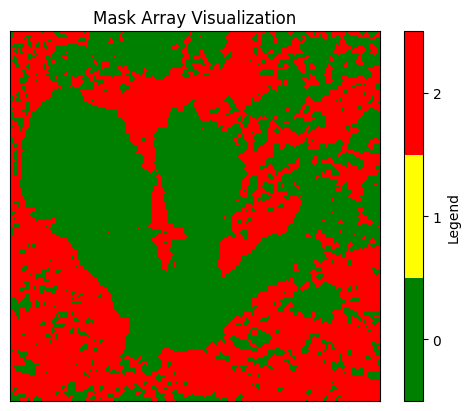

In [61]:
display_mask_array_bloom(predicted_class[0])

In [85]:
model = tf.keras.models.load_model('unet_model_multi_class.h5')

# Compile the model again
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=10)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 138s 12s/step - accuracy: 0.8733 - loss: 0.4528 - val_accuracy: 0.8501 - val_loss: 0.3416
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 229s 21s/step - accuracy: 0.8887 - loss: 0.3048 - val_accuracy: 0.9209 - val_loss: 0.2475
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 122s 10s/step - accuracy: 0.9239 - loss: 0.2353 - val_accuracy: 0.9238 - val_loss: 0.2270
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.9259 - loss: 0.2222 - val_accuracy: 0.9286 - val_loss: 0.2116
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.9313 - loss: 0.2033 - val_accuracy: 0.9341 - val_loss: 0.1925
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.9398 - loss: 0.1765 - val_accuracy: 0.9390 - val_loss: 0.1770
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.9386 - loss: 0.1740 - val_accuracy: 0.9456 - val_loss: 0.1565
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.9451 - loss: 0.1533 - val_accuracy: 0.9505 - val

  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl.metadata (1.1 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl.metadata (873 bytes)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached rsa-4.9-py3-none-any.whl.metadata (4.2 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)
   ---------------------------------------- 0.0/266.3 MB ? eta -:--:--
   ---------------------------------------- 2.1/266.3 MB 39.0 MB/s eta 0:00:07
   ---------------------------------------- 3.1/266.3 MB 10.2 MB/s eta 0:00:26
    --------------------------------------- 4.2/266.3 MB 6.6 MB/s eta 0:00:40
    --------------------------------------- 4.2/266.3 MB 6.6 MB/s eta 0:00:40
    --------------------------------------- 

  You can safely remove it manually.
  You can safely remove it manually.


In [86]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Save the model
model.save('unet_model_multi_class.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9609 - loss: 0.1120


Validation Loss: 0.1119661033153534
Validation Accuracy: 0.9608578085899353


In [63]:
!pip install pandas openpyxl imageio matplotlib

  Using cached imageio-2.36.0-py3-none-any.whl.metadata (5.2 kB)
Using cached imageio-2.36.0-py3-none-any.whl (315 kB)


In [1]:
import numpy as np

def create_masks_cloud_land(multispectral_image):
    """
    Create cloud and land masks from a multispectral image.

    Parameters:
    - multispectral_image: A 3D NumPy array (height x width x bands).
                          Expected bands: [Red, Green, Blue, NIR, SWIR]

    Returns:
    - cloud_mask: A binary mask (0 - land, 1 - cloud).
    - land_mask: A binary mask (0 - water, 1 - land).
    """
    # Assuming the bands are ordered as follows:
    # [Red, Green, Blue, NIR, SWIR]
    red = multispectral_image[:, :, 0]
    green = multispectral_image[:, :, 1]
    blue = multispectral_image[:, :, 2]
    nir = multispectral_image[:, :, 3]
    swir = multispectral_image[:, :, 4]

    # Cloud Masking using a simple threshold on the SWIR band
    cloud_mask = np.where((red == 1) & (blue == 1) & (green == 1), 1, 0)

    # Create a land mask using NIR and Red bands
    land_mask = np.where((nir > red) & (nir > 0.1), 1, 0)  # Example condition for land

    return cloud_mask.astype(np.uint8), land_mask.astype(np.uint8)

def create_mask(cloud_mask, land_mask):
    """
    Create a combined mask from cloud and land masks.

    Parameters:
        cloud_mask (np.ndarray): A 2D array where 1 indicates clouds and 0 indicates no clouds.
        land_mask (np.ndarray): A 2D array where 1 indicates land and 0 indicates no land.

    Returns:
        np.ndarray: A 2D array where:
                    - 1 indicates clouds,
                    - 2 indicates land,
                    - 3 indicates water.
    """
    # Get the dimensions of the masks
    height, width = cloud_mask.shape

    # Step 1: Initialize the result array with water (value 3)
    result_mask = np.full((height, width), 3)

    # Step 2: Apply the land mask (setting value to 2 for land)
    result_mask[land_mask == 1] = 2

    # Step 3: Apply the cloud mask (setting value to 1 for clouds)
    result_mask[cloud_mask == 1] = 1

    return result_mask

def create_mask_final(fai_mask, land_mask, cloud_mask):
    """
    Create a combined mask from cloud and land masks.

    Parameters:
        cloud_mask (np.ndarray): A 2D array where 1 indicates clouds and 0 indicates no clouds.
        land_mask (np.ndarray): A 2D array where 1 indicates land and 0 indicates no land.

    Returns:
        np.ndarray: A 2D array where:
                    - 1 indicates clouds,
                    - 2 indicates land,
                    - 3 indicates water.
    """
    # Get the dimensions of the masks
    result_mask = fai_mask

    # Step 3: Apply the cloud mask (setting value to 1 for clouds)
    result_mask[cloud_mask == 1] = 4
    result_mask[land_mask == 1] = 3

    return result_mask

import imageio

def load_float32_rgb_image(image_path):
    """
    Load an RGB PNG image and convert it to a float32 NumPy array.

    Parameters:
    image_path (str): Path to the PNG image.

    Returns:
    numpy.ndarray: Image data as a float32 NumPy array.
    """
    # Read the image using imageio
    image = imageio.imread(image_path)


    return image

def calculate_fai(red, nir, swir):
    # FAI formula
    fai = nir - (red + (swir - red) * (842 - 665) / (1610 - 665))
    return fai

def scale_array(array, scale_factor):
    """
    Scales the elements of a 2D array by a given factor.

    Parameters:
    array (np.ndarray): The input 2D array to be scaled.
    scale_factor (float): The factor by which to scale the array elements.

    Returns:
    np.ndarray: The scaled 2D array.
    """
    if not isinstance(array, np.ndarray):
        raise ValueError("Input must be a numpy array.")
    
def display_image_from_list(data_list, brightness_factor=3.5/255, display_image=False, color_map='viridis', processed=False, save_img=False):
    """
    Convert a list to an image and display it.

    Parameters:
    - data_list (list): The input list representing the image.
    - brightness_factor (float): Factor to increase brightness.
    - display_image (bool): Whether to display the image.
    - color_map (str): Colormap for displaying the image.
    - processed (bool): If true, skips brightness adjustment.
    - save_img (bool): Whether to save the image.
    """

    image = np.array(data_list)
    scaled_image = image * brightness_factor
    clipped_image = np.clip(scaled_image, 0, 1)

    if processed:
        clipped_image = image

    if not display_image:
        return clipped_image

    plt.imshow(clipped_image, cmap=color_map, vmin=0, vmax=1)
    plt.axis('off')

    if save_img:
        # Determine the dimensions of the image
        height, width = clipped_image.shape[:2]

        # Create the filename based on the shape
        image_name = f"{height}x{width}.png"  # Save as '100x100.png', '255x255.png', etc.

        plt.savefig(image_name, format='png', dpi=300, bbox_inches='tight', pad_inches=0)

        image = Image.open(image_name)
        image = image.resize((255, 255), Image.LANCZOS)
        image.save(image_name)  # Save the resized image

        # Clear the plot for the next iteration
        plt.clf()  # Clear the current figure

    plt.show()
    return clipped_image

def generate_image_paths(df):
    """
    Generate and display image paths for each date in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing a column 'Unique_Dates' with date strings.

    Returns:
        None
    """
    for index, row in df.iterrows():
        date_str = row['Unique_Dates']  # Extract the date string from the DataFrame
        
        
        # Generate and display paths for all 12 band indices
        for band_index in range(12):  # Band indices from 0 to 11
            path = f"all_bands_filtered_dates/msi_{band_index:02d}_{date_str}.png"
            print(path)  # Display the generated path
            
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

def display_mask_array(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['blue', 'green', 'red'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array - 1

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    plt.title("Mask Array Visualization")
    plt.colorbar(ticks=[0, 1, 2], label='Legend')
    plt.clim(-0.5, 2.5)  # Adjust color limits
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    plt.show()
    
def display_mask_array_bloom(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['green', 'yellow', 'red'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array 

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
    plt.title("Mask Array Visualization")
    plt.colorbar(ticks=[0, 1, 2], label='Legend')
    plt.clim(-0.5, 2.5)  # Adjust color limits
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    plt.show()

def save_mask_array_bloom(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['green', 'yellow', 'red'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array 

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
   
  
    plt.clim(-0.5, 2.5)  # Adjust color limits
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    
    output_dir = r"D:\3_apps\5_vscode_projects\final_project\labelling_fai"
    date_str = "sample_mask"
    image_path = os.path.join(output_dir, f"fai_image_{date_str}.png")
    plt.savefig(image_path, format='png', dpi=300, bbox_inches='tight', pad_inches=0)
    image = Image.open('fai_image_sample_mask.png')
    image = image.resize((255, 255), Image.LANCZOS)
    image.save(image_path)  # Save the resized image
    plt.show()

def display_mask_array_final(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['green', 'yellow', 'red','black','white'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array 

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=4)
    plt.title("Mask Array Visualization")
    plt.colorbar(ticks=[0, 1, 2,3,4], label='Legend')
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    plt.show()
    
def save_mask_array_final(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['green', 'yellow', 'red','black','white'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array 

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=4)
   
  
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    
    output_dir = r"D:\3_apps\5_vscode_projects\final_project\labelling_fai"
    date_str = "sample_mask"
    image_path = os.path.join(output_dir, f"fai_image_{date_str}.png")
    plt.savefig(image_path, format='png', dpi=300, bbox_inches='tight', pad_inches=0)
    image = Image.open('fai_image_sample_mask.png')
    image = image.resize((255, 255), Image.LANCZOS)
    image.save(image_path)  # Save the resized image
    plt.show()
    
def save_mask_array(mask_array):
    """
    Display a mask array with three distinct values as an image.

    Parameters:
    - mask_array: A 2D NumPy array containing values (1 for clouds, 2 for land, 3 for water).
    """
    if not isinstance(mask_array, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    if mask_array.ndim != 2 or mask_array.shape[0] == 0 or mask_array.shape[1] == 0:
        raise ValueError("Input must be a 2D array with non-zero dimensions.")

    # Create a colormap for the three values
    # Assigning colors: 1 (clouds) = red, 2 (land) = green, 3 (water) = blue
    cmap = mcolors.ListedColormap(['blue', 'green', 'red'])  # Map values to colors

    # Adjust the mask_array to have values 0, 1, 2 for colormap
    # Since the mask has values 1, 2, 3, we subtract 1 to map them to 0, 1, 2
    normalized_array = mask_array - 1

    # Display the array
    plt.imshow(normalized_array, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
   
  
    plt.clim(-0.5, 2.5)  # Adjust color limits
    plt.xticks(ticks=[], labels=[])  # Hide x ticks
    plt.yticks(ticks=[], labels=[])  # Hide y ticks
    
    output_dir = r"D:\3_apps\5_vscode_projects\final_project\labelling_fai"
    date_str = "sample_mask"
    image_path = os.path.join(output_dir, f"fai_image_{date_str}.png")
    plt.savefig(image_path, format='png', dpi=300, bbox_inches='tight', pad_inches=0)
    image = Image.open('fai_image_sample_mask.png')
    image = image.resize((255, 255), Image.LANCZOS)
    image.save(image_path)  # Save the resized image
    plt.show()
    
def classify_bloom(fai):
    # Simple thresholding to classify bloom types
    labels = np.zeros_like(fai)

    labels[fai < 0.01] = 0  # No Bloom
    labels[(fai >= 0.01) & (fai < 0.05)] = 1  # Moderate Bloom
    labels[fai >= 0.05] = 2  # Severe Bloom

    return labels

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

def load_data(df):
    """
    Load the spectral bands and FAIs for each date in the DataFrame.
    Convert FAI values to one-hot encoding for multi-class segmentation.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Unique_Dates' column.

    Returns:
        X (np.array): Input data (bands).
        y (np.array): One-hot encoded output data (FAI masks).
    """
    X = []
    y = []

    for index, row in df.iterrows():
        date_str = pd.to_datetime(row['Unique_Dates']).strftime('%Y-%m-%d')
        
        band2 = np.load(f'msi_array/msi_array_band2_{date_str}.npy')
        band3 = np.load(f'msi_array/msi_array_band3_{date_str}.npy')
        band4 = np.load(f'msi_array/msi_array_band4_{date_str}.npy')
        band8 = np.load(f'msi_array/msi_array_band8_{date_str}.npy')
        band11 = np.load(f'msi_array/msi_array_band11_{date_str}.npy')
        
        fai = np.load(f'fai_mask/fai_mask_{date_str}.npy')
        
        # Stack the bands to create the input (shape: 255, 255, 5)
        X.append(np.stack([band2, band3, band4, band8, band11], axis=-1))
        
        # Convert the FAI mask to one-hot encoding (shape: 255, 255, 3)
        fai_one_hot = to_categorical(fai, num_classes=3)
        y.append(fai_one_hot)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

In [48]:
file_path = 'unique_dates.xlsx'
df_relevant_dates = pd.read_excel(file_path)
X, y = load_data(df_relevant_dates)

In [65]:
df_relevant_dates

,Unique_Dates
0,2015-10-21
1,2015-12-10
2,2016-01-09
3,2016-03-19
4,2016-04-28
...,...
127,2024-09-08
128,2024-09-23
129,2024-09-28
130,2024-10-03


In [58]:
X[:4].shape

(4, 255, 255, 5)

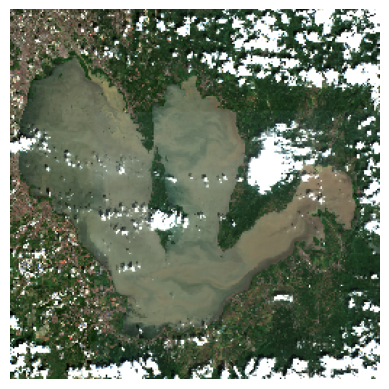

In [55]:
red = X[0:1, :, :, 2:3]
red =red [0, :, :, 0]

green = X[0:1, :, :, 1:2]
green =green[0, :, :, 0]

blue = X[0:1, :, :, 0:1]
blue  =blue [0, :, :, 0]


# Stack the channels to create an RGB image
rgb_image = np.stack((red, green, blue), axis=-1)

rgb_image = display_image_from_list(rgb_image, brightness_factor=3.5/10000, processed=True, display_image= True,save_img=False)


In [59]:
X.shape

(132, 255, 255, 5)

In [60]:
from PIL import Image
import numpy as np

# Step 1: Load the image
image = Image.open("fai_image_sample_mask_black_white.png")

# Step 2: Convert to grayscale (if not already)
image = image.convert("L")  # 'L' mode is grayscale

# Step 3: Apply threshold to convert grayscale to binary (0 or 255)
# Assuming pixel intensity < 128 is black and >= 128 is white
threshold = 128
binary_image = np.array(image) > threshold

# Step 4: Convert boolean array to integer (1 for black, 0 for white)
binary_array = binary_image.astype(int)

2015-10-21 00:00:00


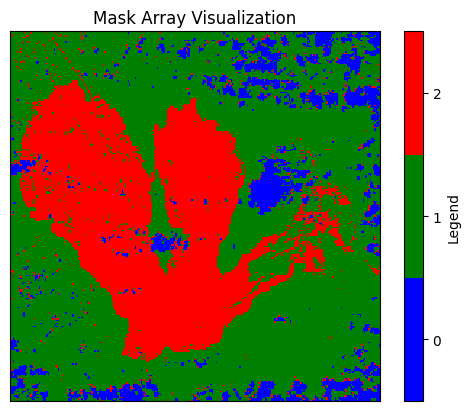

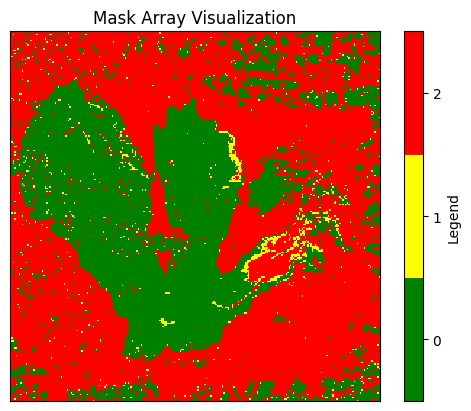

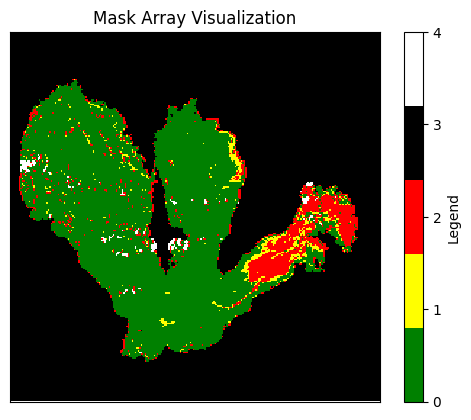

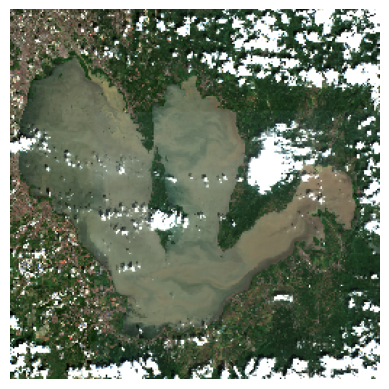

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


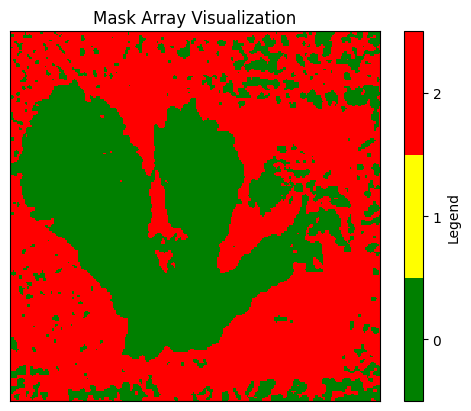

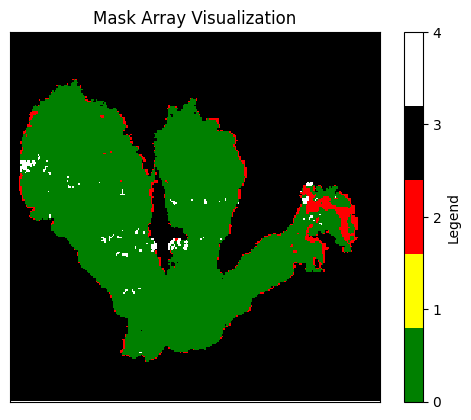

In [74]:
i = 0
print(df_relevant_dates['Unique_Dates'].iloc[0])

red = X[i:i+1, :, :, i+2:i+3]
red =red [0, :, :, 0]

green = X[i:i+1, :, :, i+1:i+2]
green =green[0, :, :, 0]

blue = X[i:i+1, :, :, i:i+1]
blue  =blue [0, :, :, 0]

nir = X[i:i+1, :, :, i+3:i+4]
nir =nir [0, :, :, 0]

swir = X[i:i+1, :, :, i+4:i+5]
swir  =swir [0, :, :, 0]

band2 = red
band3 = green
band4 = blue 
band8 = nir
band11 = swir


fai = calculate_fai(band4, band8, band11)
        
        
combined_array = np.stack((band4,band3,band2,band8,band11 ), axis=-1)

cloud_mask, land_mask= create_masks_cloud_land(combined_array)
        
result_mask = create_mask(cloud_mask, land_mask)

display_mask_array(result_mask)

labels = classify_bloom(fai)
 

display_mask_array_bloom(labels)

final_image = create_mask_final(labels, binary_array,cloud_mask)

display_mask_array_final(final_image)

rgb_image = np.stack((red, green, blue), axis=-1)

rgb_image = display_image_from_list(rgb_image, brightness_factor=3.5/10000, processed=True, display_image= True,save_img=False)

# Load the model (if needed)
model = tf.keras.models.load_model('unet_model_multi_class.h5')

# Predict on new data (for example, the first image from the validation set)
predictions = model.predict(X[i:i+1])

# The predictions will be probabilities for each class, so you can take the class with the highest probability
predicted_class = np.argmax(predictions, axis=-1)

display_mask_array_bloom(predicted_class[0])


final_image = create_mask_final(predicted_class[0], binary_array,cloud_mask)

display_mask_array_final(final_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


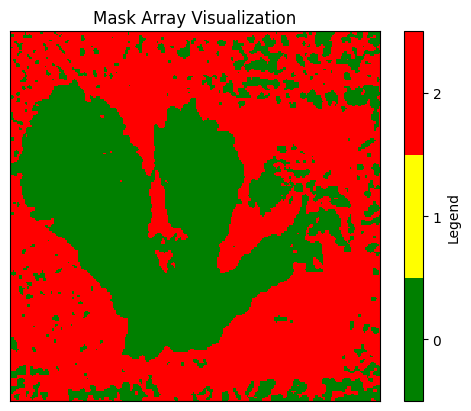

In [10]:
# Load the model (if needed)
model = tf.keras.models.load_model('unet_model_multi_class.h5')

# Predict on new data (for example, the first image from the validation set)
predictions = model.predict(X[:1])

# The predictions will be probabilities for each class, so you can take the class with the highest probability
predicted_class = np.argmax(predictions, axis=-1)

display_mask_array_bloom(predicted_class[0])